<a href="https://colab.research.google.com/github/DylanJJH/590/blob/master/A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Autoencoder

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
import random
tfkl = tfk.layers

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32')/255
y_test = y_test.astype('float32')/255

In [4]:
# train
input_img=tfkl.Input(shape=(32,32,3))

model=tfkl.Conv2D(32,(3,3),activation='relu',padding='same')(input_img)
model=tfkl.MaxPooling2D((2,2),padding='same')(model)
model=tfkl.Conv2D(16,(3,3),activation='relu',padding='same')(model)
model=tfkl.MaxPooling2D((2,2),padding='same')(model)
model=tfkl.Conv2D(16,(3,3),activation='relu',padding='same')(model)
encoded=tfkl.MaxPooling2D((2,2),padding='same')(model)

model=tfkl.Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(encoded)
model=tfkl.UpSampling2D((2,2))(model)
model=tfkl.Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(model)
model=tfkl.UpSampling2D((2,2))(model)
model=tfkl.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(model)
model=tfkl.UpSampling2D((2,2))(model)
decoded=tfkl.Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')(model)

autoencoder=Model(input_img,decoded)
autoencoder.compile(optimizer='adam',metrics=['accuracy'],loss='mse')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)         

In [5]:
results=autoencoder.fit(
    x_train,x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, x_test))

Epoch 1/20
391/391 [==============================] - 168s 430ms/step - loss: 0.0217 - accuracy: 0.5708 - val_loss: 0.0152 - val_accuracy: 0.6064
Epoch 2/20
391/391 [==============================] - 169s 431ms/step - loss: 0.0144 - accuracy: 0.6319 - val_loss: 0.0140 - val_accuracy: 0.6517
Epoch 3/20
391/391 [==============================] - 172s 441ms/step - loss: 0.0130 - accuracy: 0.6675 - val_loss: 0.0124 - val_accuracy: 0.6830
Epoch 4/20
391/391 [==============================] - 175s 447ms/step - loss: 0.0122 - accuracy: 0.6924 - val_loss: 0.0118 - val_accuracy: 0.6996
Epoch 5/20
391/391 [==============================] - 168s 431ms/step - loss: 0.0116 - accuracy: 0.7038 - val_loss: 0.0118 - val_accuracy: 0.7046
Epoch 6/20
391/391 [==============================] - 168s 430ms/step - loss: 0.0113 - accuracy: 0.7103 - val_loss: 0.0110 - val_accuracy: 0.7195
Epoch 7/20
391/391 [==============================] - 168s 429ms/step - loss: 0.0110 - accuracy: 0.7162 - val_loss: 0.0110 -

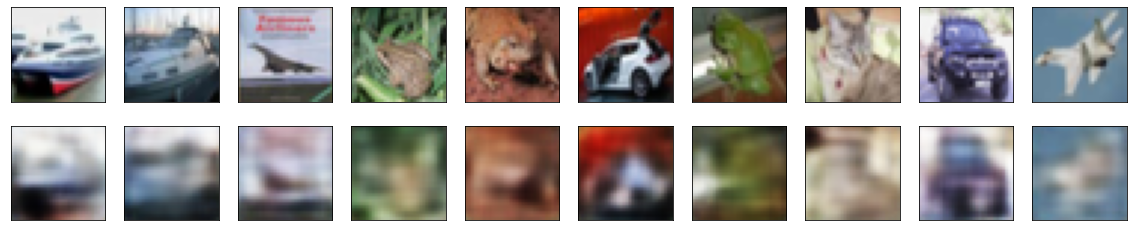

In [9]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2. Image Classification

## 2.1 Deep CNN

In [15]:
tf.one_hot(y_train,depth=10)

<tf.Tensor: shape=(50000, 1, 10), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [27]:
# 2 conv layer, (3,3) kernel size, stride 1, and valid padding
CNN=Sequential()
CNN.add(tfkl.Conv2D(32,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=(32,32,3)))
CNN.add(tfkl.MaxPooling2D((2,2)))
CNN.add(tfkl.Conv2D(16,kernel_size=(3,3),activation='relu'))
CNN.add(tfkl.MaxPooling2D((2,2)))
CNN.add(tfkl.Dropout(0.4))
CNN.add(tfkl.Flatten())
CNN.add(tfkl.Dense(64,activation='relu'))
CNN.add(tfkl.Dropout(0.4))
CNN.add(tfkl.Dense(10,activation="softmax"))
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [28]:
CNN.compile(optimizer=tfk.optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
results=CNN.fit(
    x_train,y_train,
    epochs=5,
    steps_per_epoch=500,
    batch_size=128,
    validation_data=(x_test,y_test))

Epoch 1/5
500/500 [==============================] - 51s 102ms/step - loss: 2.1137 - accuracy: 0.3424 - val_loss: 2.2171 - val_accuracy: 0.0694
Epoch 2/5
500/500 [==============================] - 51s 102ms/step - loss: 2.0714 - accuracy: 0.3850 - val_loss: 2.1970 - val_accuracy: 0.0578
Epoch 3/5
500/500 [==============================] - 51s 103ms/step - loss: 2.0414 - accuracy: 0.4147 - val_loss: 2.3134 - val_accuracy: 0.0630
Epoch 4/5
455/500 [==========================>...] - 47s 103ms/step - loss: 2.0231 - accuracy: 0.4341 - val_loss: 2.2397 - val_accuracy: 0.0711


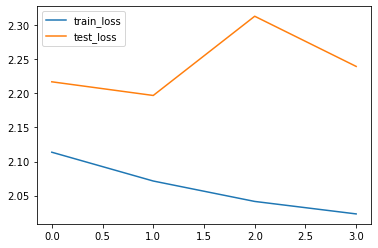

In [32]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss','test_loss'])

## 2.2 Transfer learning

In [41]:
VGG=VGG16(input_shape=(32,32,3), weights='imagenet', include_top=False)
Transfer_model=Sequential()
Transfer_model.add(VGG)
Transfer_model.add(tfkl.Flatten())
Transfer_model.add(tfkl.Dense(32, activation='relu'))
Transfer_model.add(tfkl.Dropout(0.5))
Transfer_model.add(tfkl.Dense(10, activation='softmax'))
Transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 14,731,434
Trainable params: 14,731,434
Non-trainable params: 0
_________________________________________________________________


In [42]:
Transfer_model.compile(optimizer=tfk.optimizers.RMSprop(),loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
results=Transfer_model.fit(
    x_train,y_train,
    epochs=5,
    steps_per_epoch=100,
    batch_size=16,
    validation_data=(x_test, y_test))

Epoch 1/5
100/100 [==============================] - 273s 3s/step - loss: 2.3507 - accuracy: 0.1100 - val_loss: 2.4612 - val_accuracy: 0.0000e+00
Epoch 2/5
100/100 [==============================] - 269s 3s/step - loss: 2.3536 - accuracy: 0.1075 - val_loss: 2.4612 - val_accuracy: 0.0000e+00
Epoch 3/5
100/100 [==============================] - 269s 3s/step - loss: 2.3604 - accuracy: 0.1006 - val_loss: 2.4612 - val_accuracy: 0.0000e+00
Epoch 4/5
100/100 [==============================] - 271s 3s/step - loss: 2.3666 - accuracy: 0.0950 - val_loss: 2.4612 - val_accuracy: 0.0000e+00
Epoch 5/5
100/100 [==============================] - 271s 3s/step - loss: 2.3629 - accuracy: 0.0981 - val_loss: 2.4612 - val_accuracy: 0.0000e+00


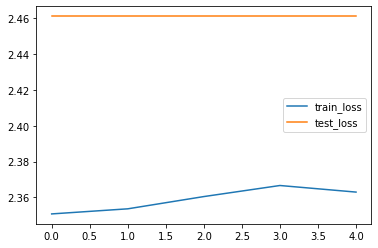

In [44]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss','test_loss'])

# 3. Text Classification

## 3.1 RNN


In [46]:
spam = pd.read_csv('SPAM_detection.csv')

In [49]:
spam['Message'] = spam['Message'].str.lower()
x=spam['Message'].values
x=np.asarray(x)
y=spam['category_val'].values
y=np.asarray(y)

In [50]:
token=Tokenizer()
token.fit_on_texts(x)
x=token.texts_to_sequences(x)
x=sequence.pad_sequences(x)

In [52]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=random.randint(0,100))
vocab_size=len(token.word_index)+1

In [53]:
RNN=tfk.Sequential()
RNN.add(tfkl.Embedding(vocab_size, 16, input_length=189))
RNN.add(tfkl.LSTM(64,return_sequences=True))
RNN.add(tfkl.GlobalMaxPool1D())
RNN.add(tfkl.Dropout(0.5))
RNN.add(tfkl.Dense(64,activation="relu"))
RNN.add(tfkl.Dropout(0.5))
RNN.add(tfkl.Dense(1,activation="sigmoid"))
RNN.compile(optimizer=tfk.optimizers.RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])
RNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 16)           144080    
_________________________________________________________________
lstm (LSTM)                  (None, 189, 64)           20736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [66]:
results_rnn=RNN.fit(x_train,y_train,
        epochs=10,
        steps_per_epoch=30,
        batch_size=32,
        validation_data=(x_test,y_test))

Epoch 1/10
30/30 [==============================] - 4s 143ms/step - loss: 1.6006e-04 - accuracy: 1.0000 - val_loss: 0.3536 - val_accuracy: 0.9749
Epoch 2/10
30/30 [==============================] - 4s 143ms/step - loss: 1.0273e-05 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.9767
Epoch 3/10
30/30 [==============================] - 4s 142ms/step - loss: 0.0157 - accuracy: 0.9990 - val_loss: 0.3847 - val_accuracy: 0.9695
Epoch 4/10
30/30 [==============================] - 4s 144ms/step - loss: 1.0493e-04 - accuracy: 1.0000 - val_loss: 0.3492 - val_accuracy: 0.9749
Epoch 5/10
30/30 [==============================] - 4s 141ms/step - loss: 1.3545e-04 - accuracy: 1.0000 - val_loss: 0.3985 - val_accuracy: 0.9725
Epoch 6/10
30/30 [==============================] - 4s 140ms/step - loss: 1.4987 - accuracy: 0.9438 - val_loss: 0.3012 - val_accuracy: 0.9773
Epoch 7/10
30/30 [==============================] - 4s 142ms/step - loss: 5.4695e-04 - accuracy: 1.0000 - val_loss: 0.3044 - val_acc

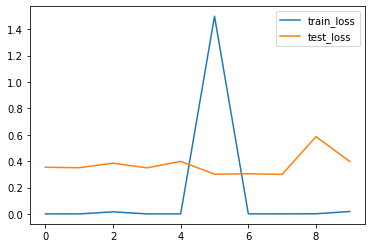

In [67]:
plt.plot(results_rnn.history['loss'])
plt.plot(results_rnn.history['val_loss'])
plt.legend(['train_loss','test_loss'])

## CNN

In [74]:
CNN=tfk.Sequential()
CNN.add(tfkl.Embedding(vocab_size, 16, input_length=189))
CNN.add(tfkl.Conv1D(32,kernel_size=2,strides=1,activation='relu',padding='same'))
CNN.add(tfkl.MaxPooling1D())
CNN.add(tfkl.Conv1D(32, kernel_size=2,strides=1,activation='relu',padding='same'))
CNN.add(tfkl.Dropout(0.3))
CNN.add(tfkl.Conv1D(32,kernel_size=2,strides=1,activation='relu',padding='same'))
CNN.add(tfkl.Flatten())
CNN.add(tfkl.Dense(32,activation='relu'))
CNN.add(tfkl.Dense(1,activation='sigmoid'))                    
CNN.compile(optimizer=tfk.optimizers.RMSprop(), loss='binary_crossentropy',metrics=['accuracy'])
CNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 189, 16)           144080    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 189, 32)           1056      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 94, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 94, 32)            2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 94, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 94, 32)            2080      
_________________________________________________________________
flatten_6 (Flatten)          (None, 3008)             

In [75]:
results_cnn=CNN.fit(x_train,y_train,
        epochs=10,
        steps_per_epoch=30,
        batch_size=32,
        validation_data=(x_test,y_test))

Epoch 1/10
30/30 [==============================] - 1s 27ms/step - loss: 0.4180 - accuracy: 0.8365 - val_loss: 0.3837 - val_accuracy: 0.8612
Epoch 2/10
30/30 [==============================] - 1s 22ms/step - loss: 0.3092 - accuracy: 0.8823 - val_loss: 0.2744 - val_accuracy: 0.8612
Epoch 3/10
30/30 [==============================] - 1s 22ms/step - loss: 0.1820 - accuracy: 0.9094 - val_loss: 0.1661 - val_accuracy: 0.9629
Epoch 4/10
30/30 [==============================] - 1s 22ms/step - loss: 0.1646 - accuracy: 0.9594 - val_loss: 0.1508 - val_accuracy: 0.9647
Epoch 5/10
30/30 [==============================] - 1s 22ms/step - loss: 0.1295 - accuracy: 0.9749 - val_loss: 0.1424 - val_accuracy: 0.9731
Epoch 6/10
30/30 [==============================] - 1s 21ms/step - loss: 0.1080 - accuracy: 0.9833 - val_loss: 0.1388 - val_accuracy: 0.9767
Epoch 7/10
30/30 [==============================] - 1s 23ms/step - loss: 0.1400 - accuracy: 0.9823 - val_loss: 0.1630 - val_accuracy: 0.9749
Epoch 8/10
30

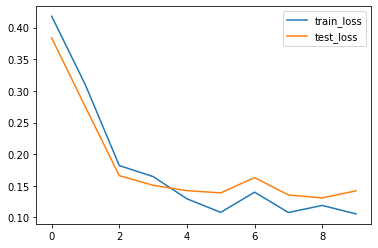

In [76]:
plt.plot(results_cnn.history["loss"])
plt.plot(results_cnn.history["val_loss"])
plt.legend(['train_loss','test_loss'])

## 3.3

In [77]:
pred_rnn=RNN.predict(x_test)
pred_cnn=CNN.predict(x_test)

In [82]:
fpr_rnn, tpr_rnn, rnn_ = roc_curve(y_test, pred_rnn)
fpr_cnn, tpr_cnn, cnn_ = roc_curve(y_test, pred_cnn)

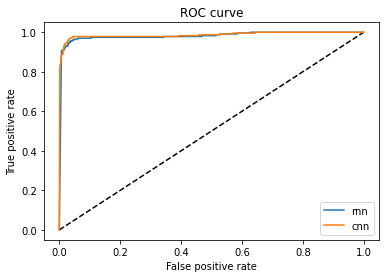

In [83]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label='rnn')
plt.plot(fpr_cnn, tpr_cnn, label='cnn')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()